In [1]:
import random
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.v2 import Compose, Normalize, ToPILImage, Resize, ToDtype

from torch.utils.data import random_split, WeightedRandomSampler

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

## Architecture class

In [26]:
class Architecture(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class

        # We start by storing the arguments as attributes
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model,
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

        # for hook purposes
        self.handles = {}
        self.visualization = {}

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer

        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        # Once the data loader and step function, this is the same
        # mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    # this function was updated in this class
    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        try:
            self.train_loader.sampler.generator.manual_seed(seed)
        except AttributeError:
            pass

    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval()
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def count_parameters(self):
      return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

    @staticmethod
    def _visualize_tensors(axs, x, y=None, yhat=None, layer_name='', title=None):
        # The number of images is the number of subplots in a row
        n_images = len(axs)
        # Gets max and min values for scaling the grayscale
        minv, maxv = np.min(x[:n_images]), np.max(x[:n_images])
        # For each image
        for j, image in enumerate(x[:n_images]):
            ax = axs[j]
            # Sets title, labels, and removes ticks
            if title is not None:
                ax.set_title(f'{title} #{j}', fontsize=12)
            shp = np.atleast_2d(image).shape
            ax.set_ylabel(
                f'{layer_name}\n{shp[0]}x{shp[1]}',
                rotation=0, labelpad=40
            )
            xlabel1 = '' if y is None else f'\nLabel: {y[j]}'
            xlabel2 = '' if yhat is None else f'\nPredicted: {yhat[j]}'
            xlabel = f'{xlabel1}{xlabel2}'
            if len(xlabel):
                ax.set_xlabel(xlabel, fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])

            # Plots weight as an image
            ax.imshow(
                np.atleast_2d(image.squeeze()),
                cmap='gray',
                vmin=minv,
                vmax=maxv
            )
        return

    def visualize_filters(self, layer_name, **kwargs):
        try:
            # Gets the layer object from the model
            layer = self.model
            for name in layer_name.split('.'):
                layer = getattr(layer, name)
            # We are only looking at filters for 2D convolutions
            if isinstance(layer, nn.Conv2d):
                # Takes the weight information
                weights = layer.weight.data.cpu().numpy()
                # weights -> (channels_out (filter), channels_in, H, W)
                n_filters, n_channels, _, _ = weights.shape

                # Builds a figure
                size = (2 * n_channels + 2, 2 * n_filters)
                fig, axes = plt.subplots(n_filters, n_channels,
                                        figsize=size)
                axes = np.atleast_2d(axes)
                axes = axes.reshape(n_filters, n_channels)
                # For each channel_out (filter)
                for i in range(n_filters):
                    Architecture._visualize_tensors(
                        axes[i, :],
                        weights[i],
                        layer_name=f'Filter #{i}',
                        title='Channel'
                    )

                for ax in axes.flat:
                    ax.label_outer()

                fig.tight_layout()
                return fig
        except AttributeError:
            return

    def attach_hooks(self, layers_to_hook, hook_fn=None):
        # Clear any previous values
        self.visualization = {}
        # Creates the dictionary to map layer objects to their names
        modules = list(self.model.named_modules())
        layer_names = {layer: name for name, layer in modules[1:]}

        if hook_fn is None:
            # Hook function to be attached to the forward pass
            def hook_fn(layer, inputs, outputs):
                # Gets the layer name
                name = layer_names[layer]
                # Detaches outputs
                values = outputs.detach().cpu().numpy()
                # Since the hook function may be called multiple times
                # for example, if we make predictions for multiple mini-batches
                # it concatenates the results
                if self.visualization[name] is None:
                    self.visualization[name] = values
                else:
                    self.visualization[name] = np.concatenate([self.visualization[name], values])

        for name, layer in modules:
            # If the layer is in our list
            if name in layers_to_hook:
                # Initializes the corresponding key in the dictionary
                self.visualization[name] = None
                # Register the forward hook and keep the handle in another dict
                self.handles[name] = layer.register_forward_hook(hook_fn)

    def remove_hooks(self):
        # Loops through all hooks and removes them
        for handle in self.handles.values():
            handle.remove()
        # Clear the dict, as all hooks have been removed
        self.handles = {}

    def visualize_outputs(self, layers, n_images=10, y=None, yhat=None):
        layers = filter(lambda l: l in self.visualization.keys(), layers)
        layers = list(layers)
        shapes = [self.visualization[layer].shape for layer in layers]
        n_rows = [shape[1] if len(shape) == 4 else 1
                  for shape in shapes]
        total_rows = np.sum(n_rows)

        fig, axes = plt.subplots(total_rows, n_images,
                                figsize=(1.5*n_images, 1.5*total_rows))
        axes = np.atleast_2d(axes).reshape(total_rows, n_images)

        # Loops through the layers, one layer per row of subplots
        row = 0
        for i, layer in enumerate(layers):
            start_row = row
            # Takes the produced feature maps for that layer
            output = self.visualization[layer]

            is_vector = len(output.shape) == 2

            for j in range(n_rows[i]):
                Architecture._visualize_tensors(
                    axes[row, :],
                    output if is_vector else output[:, j].squeeze(),
                    y,
                    yhat,
                    layer_name=layers[i] \
                              if is_vector \
                              else f'{layers[i]}\nfil#{row-start_row}',
                    title='Image' if (row == 0) else None
                )
                row += 1

        for ax in axes.flat:
            ax.label_outer()

        plt.tight_layout()
        return fig

    def correct(self, x, y, threshold=.5):
        self.model.eval()
        yhat = self.model(x.to(self.device))
        y = y.to(self.device)
        self.model.train()

        # We get the size of the batch and the number of classes
        # (only 1, if it is binary)
        n_samples, n_dims = yhat.shape
        if n_dims > 1:
            # In a multiclass classification, the biggest logit
            # always wins, so we don't bother getting probabilities

            # This is PyTorch's version of argmax,
            # but it returns a tuple: (max value, index of max value)
            _, predicted = torch.max(yhat, 1)
        else:
            n_dims += 1
            # In binary classification, we NEED to check if the
            # last layer is a sigmoid (and then it produces probs)
            if isinstance(self.model, nn.Sequential) and \
              isinstance(self.model[-1], nn.Sigmoid):
                predicted = (yhat > threshold).long()
            # or something else (logits), which we need to convert
            # using a sigmoid
            else:
                predicted = (F.sigmoid(yhat) > threshold).long()

        # How many samples got classified correctly for each class
        result = []
        for c in range(n_dims):
            n_class = (y == c).sum().item()
            n_correct = (predicted[y == c] == c).sum().item()
            result.append((n_correct, n_class))
        return torch.tensor(result)


    @staticmethod
    def loader_apply(loader, func, reduce='sum'):
        results = [func(x, y) for i, (x, y) in enumerate(loader)]
        results = torch.stack(results, axis=0)

        if reduce == 'sum':
            results = results.sum(axis=0)
        elif reduce == 'mean':
            results = results.float().mean(axis=0)

        return results

# Convolving in Pytorch

In [3]:
import numpy as np

random_array = np.random.rand(1, 3, 6, 6)
image = torch.as_tensor(random_array).float()

conv_multiple = nn.Conv2d(in_channels=3, out_channels=2,
                          kernel_size=3, stride=1, padding=0)
fm = conv_multiple(image)

In [4]:
fm.shape

torch.Size([1, 2, 4, 4])

In [5]:
conv_multiple.weight.shape

torch.Size([2, 3, 3, 3])

In [6]:
conv_multiple.bias.shape

torch.Size([2])

## Activation Function

In [7]:
fm = np.array([[[[-10,3,5,0],
                    [4,-3,3,-3],
                    [1,0,20,4],
                    [5,6,-10,9]]]])

tensor = torch.tensor(fm).float()

# Apply ReLU function
relu = nn.ReLU()
relu(tensor)

tensor([[[[ 0.,  3.,  5.,  0.],
          [ 4.,  0.,  3.,  0.],
          [ 1.,  0., 20.,  4.],
          [ 5.,  6.,  0.,  9.]]]])

## Pooling layer

In [8]:
pool_data = np.array([[[[181,237,170,223],
                      [229,181,89,108],
                      [109,93,48,66],
                      [158,21,71,14]]]])

tensor = torch.tensor(pool_data).float()
tensor.shape

torch.Size([1, 1, 4, 4])

In [9]:
maxpool = nn.MaxPool2d(kernel_size=2,stride=1)
pooled = maxpool(tensor)

In [10]:
pooled.shape

torch.Size([1, 1, 3, 3])

In [11]:
pooled

tensor([[[[237., 237., 223.],
          [229., 181., 108.],
          [158.,  93.,  71.]]]])

## Flattening

In [12]:
flattened = nn.Flatten()
flattened(pooled)

tensor([[237., 237., 223., 229., 181., 108., 158.,  93.,  71.]])

## LeNet5

*Source: Generated using Alexander Lenail's [NN-SVG](http://alexlenail.me/NN-SVG/) and adapted by the author. For more details, see LeCun, Y., et al (1998).  [Gradient-based learning applied to document recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf). Proceedings of the IEEE,86(11), 2278–2324*

In [13]:
lenet = nn.Sequential()

# Featurizer
# Block 1: 1@28x28 -> 6@28x28 -> 6@14x14
lenet.add_module('C1', nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2))
lenet.add_module('func1', nn.ReLU())
lenet.add_module('S2', nn.MaxPool2d(kernel_size=2))
# Block 2: 6@14x14 -> 16@10x10 -> 16@5x5
lenet.add_module('C3', nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5))
lenet.add_module('func2', nn.ReLU())
lenet.add_module('S4', nn.MaxPool2d(kernel_size=2))
# Block 3: 16@5x5 -> 120@1x1
lenet.add_module('C5', nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5))
lenet.add_module('func2', nn.ReLU())
# Flattening
lenet.add_module('flatten', nn.Flatten())

# Classification
# Hidden Layer
lenet.add_module('F6', nn.Linear(in_features=120, out_features=84))
lenet.add_module('func3', nn.ReLU())
# Output Layer
lenet.add_module('OUTPUT', nn.Linear(in_features=84, out_features=10))

In [14]:
# Function to count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [15]:
count_parameters(lenet)

61706

In [16]:
for p in lenet.parameters():
  if p.requires_grad:
    print(p.numel())

150
6
2400
16
48000
120
10080
84
840
10


# A Multiclass Classification Problem

## Data generation

In [17]:
def gen_img(start, target, fill=1, img_size=10):
    # Generates empty image
    img = np.zeros((img_size, img_size), dtype=float)

    start_row, start_col = None, None

    if start > 0:
        start_row = start
    else:
        start_col = np.abs(start)

    if target == 0:
        if start_row is None:
            img[:, start_col] = fill
        else:
            img[start_row, :] = fill
    else:
        if start_col == 0:
            start_col = 1

        if target == 1:
            if start_row is not None:
                up = (range(start_row, -1, -1),
                      range(0, start_row + 1))
            else:
                up = (range(img_size - 1, start_col - 1, -1),
                      range(start_col, img_size))
            img[up] = fill
        else:
            if start_row is not None:
                down = (range(start_row, img_size, 1),
                        range(0, img_size - start_row))
            else:
                down = (range(0, img_size - 1 - start_col + 1),
                        range(start_col, img_size))
            img[down] = fill

    return 255 * img.reshape(1, img_size, img_size)

In [18]:
def generate_dataset(img_size=10, n_images=100, binary=True, seed=17):
    np.random.seed(seed)

    starts = np.random.randint(-(img_size - 1), img_size, size=(n_images,))
    targets = np.random.randint(0, 3, size=(n_images,))

    images = np.array([gen_img(s, t, img_size=img_size)
                       for s, t in zip(starts, targets)], dtype=np.uint8)

    if binary:
        targets = (targets > 0).astype(int)

    return images, targets

In [19]:
def plot_images(images, targets, n_plot=30):
    n_rows = n_plot // 10 + ((n_plot % 10) > 0)
    fig, axes = plt.subplots(n_rows, 10, figsize=(15, 1.5 * n_rows))
    axes = np.atleast_2d(axes)

    for i, (image, target) in enumerate(zip(images[:n_plot], targets[:n_plot])):
        row, col = i // 10, i % 10
        ax = axes[row, col]
        ax.set_title('#{} - Label:{}'.format(i, target), {'size': 12})
        # plot filter channel in grayscale
        ax.imshow(image.squeeze(), cmap='gray', vmin=0, vmax=1)

    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.label_outer()

    plt.tight_layout()
    return fig

In [20]:
images, labels = generate_dataset(img_size=10, n_images=1000, binary=False, seed=17)

In [21]:
images.shape

(1000, 1, 10, 10)

In [22]:
labels.shape

(1000,)

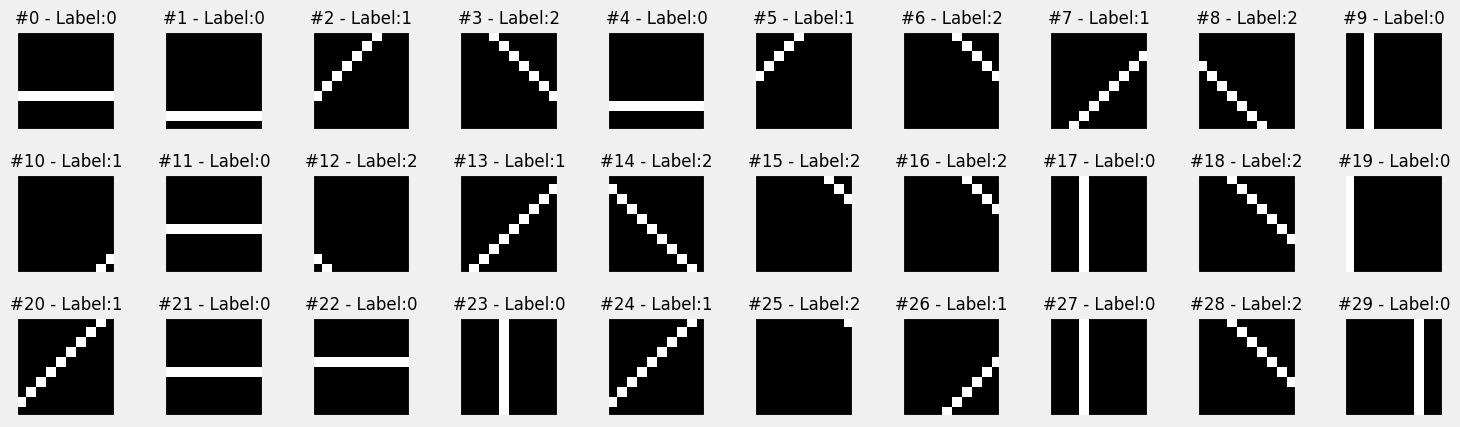

In [23]:
fig = plot_images(images, labels, n_plot=30)

## Data Preparation

In [27]:
class TransformedTensorDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform

    def __getitem__(self, index):
        x = self.x[index]

        if self.transform:
            x = self.transform(x)

        return x, self.y[index]

    def __len__(self):
        return len(self.x)

In [24]:
def index_splitter(n, splits, seed=13):
    idx = torch.arange(n)
    # Makes the split argument a tensor
    splits_tensor = torch.as_tensor(splits)
    total = splits_tensor.sum().float()
    # If the total does not add up to one
    # divide every number by the total
    if not total.isclose(torch.ones(1)[0]):
        splits_tensor = splits_tensor / total
    # Uses PyTorch random_split to split the indices
    torch.manual_seed(seed)
    return random_split(idx, splits_tensor)

def make_balanced_sampler(y):
    # Computes weights for compensating imbalanced classes
    classes, counts = y.unique(return_counts=True)
    weights = 1.0 / counts.float()
    sample_weights = weights[y.squeeze().long()]
    # Builds sampler with compute weights
    generator = torch.Generator()
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        generator=generator,
        replacement=True
    )
    return sampler

In [28]:
# Builds tensors from numpy arrays BEFORE split
# Modifies the scale of pixel values from [0, 255] to [0, 1]
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels).long()

# Uses index_splitter to generate indices for training and
# validation sets
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])
# Uses indices to perform the split
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

# We're not doing any data augmentation now
train_composer = Compose([Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])

# Uses custom dataset to apply composed transforms to each set
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# Builds a weighted random sampler to handle imbalanced classes
sampler = make_balanced_sampler(y_train_tensor)

# Uses sampler in the training set to get a balanced data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

## Loss

### Softmax

The Softmax function transforms logits (the outputs of the network before the activation function) into probabilities. For an input with \( C \) classes, the Softmax function is defined as:

$
\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{C} e^{z_j}}
$

where \( z_i \) is the logit for class \( i \) and \( C \) is the number of classes.


$$
\Large
\begin{array}
& z & = \text{logit}(p) & = \text{log odds ratio }(p) & = \text{log}\left(\frac{p}{1-p}\right)
\\
e^z & = e^{\text{logit}(p)} & = \text{odds ratio }(p) & = \left(\frac{p}{1-p}\right)
\end{array}
$$

$$
\Large
\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{c=0}^{C-1}{e^{z_c}}}
$$

$$
\Large
\text{softmax}(z) = \left[\frac{e^{z_0}}{e^{z_0}+e^{z_1}+e^{z_2}},\frac{e^{z_1}}{e^{z_0}+e^{z_1}+e^{z_2}},\frac{e^{z_2}}{e^{z_0}+e^{z_1}+e^{z_2}}\right]
$$

In [29]:
logits = torch.tensor([ 1.3863,  0.0000, -0.6931])

In [30]:
odds_ratios = torch.exp(logits)
odds_ratios

tensor([4.0000, 1.0000, 0.5000])

In [31]:
softmaxed = odds_ratios / odds_ratios.sum()
softmaxed

tensor([0.7273, 0.1818, 0.0909])

In [32]:
nn.Softmax(dim=-1)(logits)

tensor([0.7273, 0.1818, 0.0909])

### CrossEntropy Loss

Cross-entropy measures the discrepancy between the true class distribution (p) and the predicted distribution (q). The formula for cross-entropy is:

$\displaystyle
H(p, q) = -\sum_{i=0}^{C-1} p_i \log(q_i)
$

For classification problems, $(p_i)$ is 1 for the correct class and 0 for the other classes (one-hot encoding).


**Combining Softmax and Cross-Entropy**

For simplicity, consider the correct class as $(y)$. The predicted probability for the correct class $(q_y)$ using Softmax is:

$\displaystyle
q_y = \frac{e^{z_y}}{\sum_{j=0}^{C-1} e^{z_j}}
$

Inserting this into the cross-entropy formula, where $(p_y = 1)$ and $(p_i = 0)$ for $(i \neq y)$:

$\displaystyle
\text{Loss} = -\log(q_y) = -\log\left(\frac{e^{z_y}}{\sum_{j=0}^{C-1} e^{z_j}}\right)
$

**Simplifying the Formula**

We can now simplify this expression:

$\displaystyle
\text{Loss} = -\log\left(\frac{e^{z_y}}{\sum_{j=0}^{C-1} e^{z_j}}\right)
$

Applying the logarithm property $\displaystyle( \log\left(\frac{a}{b}\right) = \log(a) - \log(b) )$:

$\displaystyle
\text{Loss} = -\left(\log(e^{z_y}) - \log\left(\sum_{j=0}^{C-1} e^{z_j}\right)\right)
$

Since $\displaystyle( \log(e^{z_y}) = z_y )$:

$\displaystyle
\text{Loss} = -z_y + \log\left(\sum_{j=1}^{C} e^{z_j}\right)
$

In [33]:
import torch

# Definindo a semente e criando os logits e labels
torch.manual_seed(11)
dummy_logits = torch.randn((5, 3))
dummy_labels = torch.tensor([0, 0, 1, 2, 1])

# Função Softmax
def softmax(logits):
    exp_logits = torch.exp(logits)
    sum_exp_logits = torch.sum(exp_logits, dim=1, keepdim=True)
    return exp_logits / sum_exp_logits

# Aplicando a função Softmax aos logits
probabilities = softmax(dummy_logits)

In [34]:
probabilities

tensor([[0.2181, 0.7301, 0.0518],
        [0.1664, 0.3663, 0.4673],
        [0.2861, 0.3629, 0.3510],
        [0.0686, 0.8010, 0.1305],
        [0.3421, 0.1481, 0.5098]])

In [35]:
dummy_logits

tensor([[ 0.7376,  1.9459, -0.6995],
        [-1.3023, -0.5133, -0.2696],
        [ 0.2462,  0.4839,  0.4504],
        [-0.9568,  1.5012, -0.3136],
        [-0.2343, -1.0713,  0.1648]])

In [36]:
# Calculating cross-entropy manually
def cross_entropy_loss(probabilities, labels):
    # Getting the probabilities of the correct classes
    correct_class_probs = probabilities[range(len(labels)), labels]
    # Calculating the cross-entropy loss
    loss = -torch.log(correct_class_probs)
    return torch.mean(loss)

In [37]:
# Calculating the loss
loss = cross_entropy_loss(probabilities, dummy_labels)

print("\nLoss:")
print(loss.item())


Loss:
1.6552671194076538


In [38]:
torch.manual_seed(11)
dummy_logits = torch.randn((5, 3))
dummy_labels = torch.tensor([0, 0, 1, 2, 1])

loss_fn = nn.CrossEntropyLoss()
loss_fn(dummy_logits, dummy_labels)

tensor(1.6553)

## Model V1

### Configuration

In [39]:
torch.manual_seed(13)
model_cnn1 = nn.Sequential()

# Featurizer
# Block 1: 1@10x10 -> n_channels@8x8 -> n_channels@4x4
n_channels = 1
model_cnn1.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=n_channels, kernel_size=3))
model_cnn1.add_module('relu1', nn.ReLU())
model_cnn1.add_module('maxp1', nn.MaxPool2d(kernel_size=2))
# Flattening: n_channels * 4 * 4
model_cnn1.add_module('flatten', nn.Flatten())

In [41]:
# Classification
# Hidden Layer
model_cnn1.add_module('fc1', nn.Linear(in_features=n_channels*4*4, out_features=10))
model_cnn1.add_module('relu2', nn.ReLU())
# Output Layer
model_cnn1.add_module('fc2', nn.Linear(in_features=10, out_features=3))

### Training

In [42]:
lr = 0.1
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn1 = optim.SGD(model_cnn1.parameters(), lr=lr)

In [43]:
arch_cnn1 = Architecture(model_cnn1, multi_loss_fn, optimizer_cnn1)
arch_cnn1.set_loaders(train_loader, val_loader)

In [44]:
arch_cnn1.train(20)

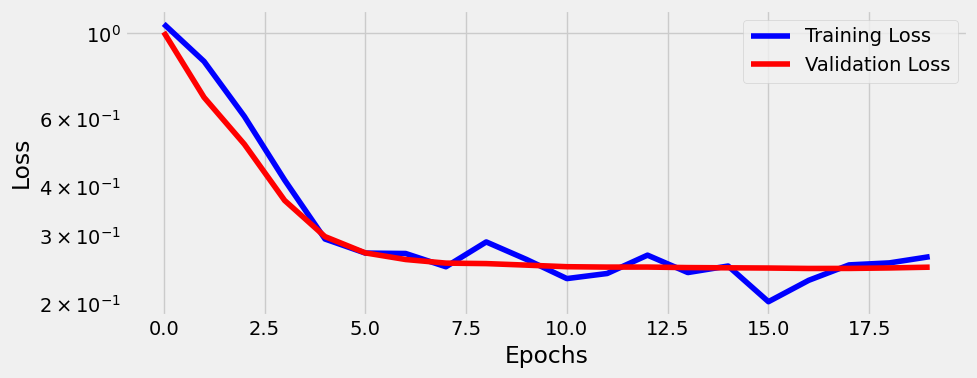

In [46]:
fig = arch_cnn1.plot_losses()

### Visualizing Filters

In [47]:
weights_filter = model_cnn1.conv1.weight.data.cpu().numpy()
weights_filter

array([[[[-0.98543113, -0.62264746,  0.12176603],
         [-0.87226605, -1.0364404 ,  0.77272683],
         [ 0.12097283,  1.0189984 ,  2.0316062 ]]]], dtype=float32)

In [48]:
weights_filter.shape

(1, 1, 3, 3)

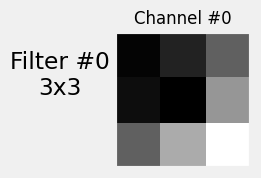

In [70]:
fig = arch_cnn1.visualize_filters('conv1', cmap='gray')

To really understand the effect this filter has on each image, we need to visualize the intermediate values produced by our model, namely, the output of each and
every layer!

### Hooks

A **hook** is simply a way to force a model to execute a function either after its
**forward pass** or after its **backward pass**. Hence, there are forward hooks and
backward hooks.

In [71]:
# Create a simple linear model with one input and one output
dummy_model = nn.Linear(1, 1)

# Create an empty list to store hook information
dummy_list = []

# Define the hook function
# This function will be called during the forward pass of the network
# The function receives three parameters:
# - layer: the current layer where the hook is registered
# - inputs: the input to the layer
# - outputs: the output from the layer
def dummy_hook(layer, inputs, outputs):
    # Append a tuple containing the layer, the input, and the output to the dummy_list
    dummy_list.append((layer, inputs, outputs))

# Register the hook to the model's layer
# During the model's execution, the hook function will be called
handle = dummy_model.register_forward_hook(dummy_hook)

# Now, whenever the dummy_model layer is executed, the dummy_hook function will be called
# and the layer, input, and output will be added to dummy_list

In [72]:
dummy_x = torch.tensor([0.3])
dummy_model(dummy_x)

tensor([-0.6054], grad_fn=<ViewBackward0>)

In [73]:
dummy_list

[(Linear(in_features=1, out_features=1, bias=True),
  (tensor([0.3000]),),
  tensor([-0.6054], grad_fn=<ViewBackward0>))]

If you call the model once
again, it will append yet another tuple to the list, and so on and so forth. This hook
is going to be hooked to our model until it is explicitly removed (hence the need to
keep the handles). To remove a hook, you can simply call its **remove()** method:

In [74]:
handle.remove()

And the hook goes bye-bye! But we did not lose the collected information, since
our variable, dummy_list, was defined outside the hook function.

In [75]:
import torch  # Import the necessary module from PyTorch

# Create a dummy input tensor with a value of 0.3
dummy_x = torch.tensor([0.3])

# Pass the dummy input through the dummy_model
dummy_model(dummy_x)
# Output of the model, which is a tensor with a value and a gradient function
# tensor([-0.2450], grad_fn=<ViewBackward0>)

# Check the dummy_list to see the stored hook information
dummy_list
# The list contains a tuple with:
# - The Linear layer used in the dummy_model
# - The input tensor passed to the layer (dummy_x)
# - The output tensor from the layer with a gradient function
# [(Linear(in_features=1, out_features=1, bias=True),
#   (tensor([0.3000]),),
#   tensor([-0.2450], grad_fn=<ViewBackward0>))]

# Remove the hook from the model
handle.remove()

In [76]:
arch_cnn1.attach_hooks(layers_to_hook=['conv1', 'relu1',
                                       'maxp1', 'flatten',
                                       'fc1', 'relu2', 'fc2'])

In [77]:
images_batch, labels_batch = next(iter(val_loader))
logits = arch_cnn1.predict(images_batch)

In [78]:
logits

array([[ -0.7025167 ,  -0.88686275,   1.2460043 ],
       [ -0.7023481 ,  -0.88708615,   1.2460485 ],
       [ -0.7022598 ,  -0.88731825,   1.2461419 ],
       [  8.937834  ,   1.8824315 ,  -6.2809005 ],
       [  7.0694046 ,   0.0285826 ,  -6.4076877 ],
       [  8.937834  ,   1.8824315 ,  -6.2809005 ],
       [ -0.7022598 ,  -0.88731825,   1.2461419 ],
       [ -0.7022598 ,  -0.88731825,   1.2461419 ],
       [ -0.7022598 ,  -0.88731825,   1.2461419 ],
       [  0.69231856,   6.4882727 ,  -5.576466  ],
       [  9.938673  ,   3.1870468 , -11.1746235 ],
       [ -0.2380904 ,   4.372193  ,  -3.1215951 ],
       [ -0.7022598 ,  -0.88731825,   1.2461419 ],
       [  1.3014423 ,   8.419593  ,  -7.7523694 ],
       [ -0.70248806,  -0.8868166 ,   1.2459629 ],
       [  9.361308  ,   2.4471712 , -10.740905  ]], dtype=float32)

In [79]:
arch_cnn1.remove_hooks()

In [80]:
predicted = np.argmax(logits, 1)
predicted

array([2, 2, 2, 0, 0, 0, 2, 2, 2, 1, 0, 1, 2, 1, 2, 0])

### Visualizing Feature Maps

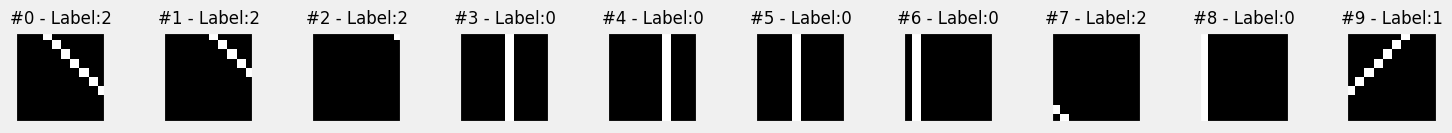

In [81]:
fig = plot_images(images_batch.squeeze(),
                  labels_batch.squeeze(),
                  n_plot=10)

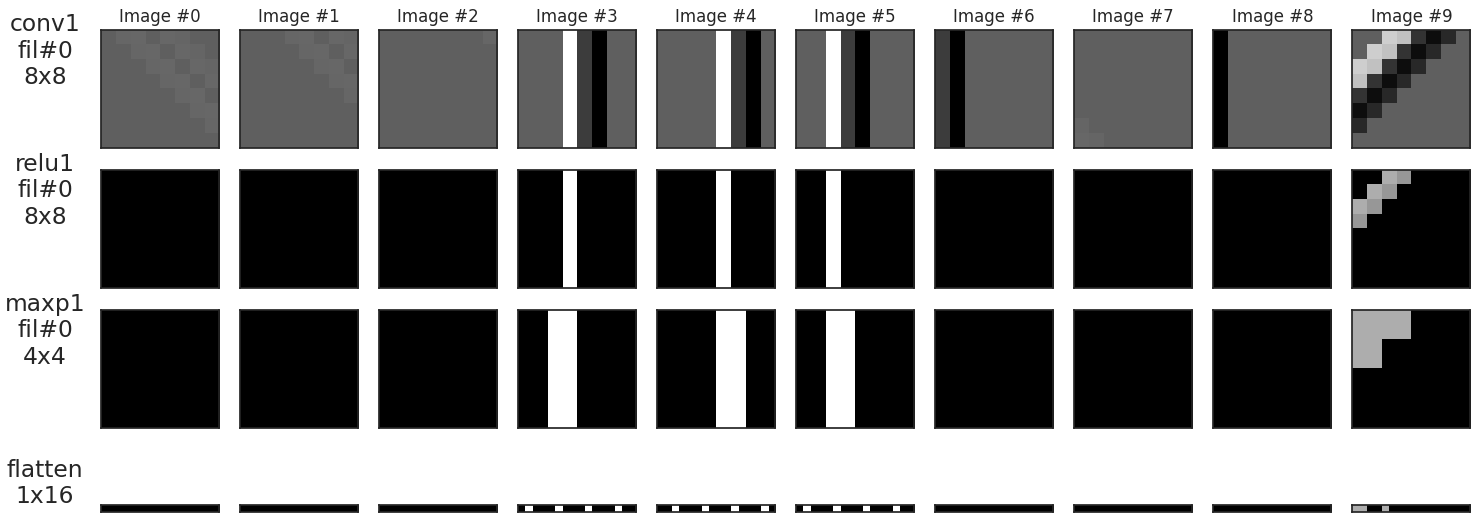

In [82]:
featurizer_layers = ['conv1', 'relu1',
                     'maxp1', 'flatten']

# with plt.style.context('seaborn-white'):
with plt.style.context('seaborn-v0_8-white'):
    fig = arch_cnn1.visualize_outputs(featurizer_layers)

### Visualizing Classifier Layers


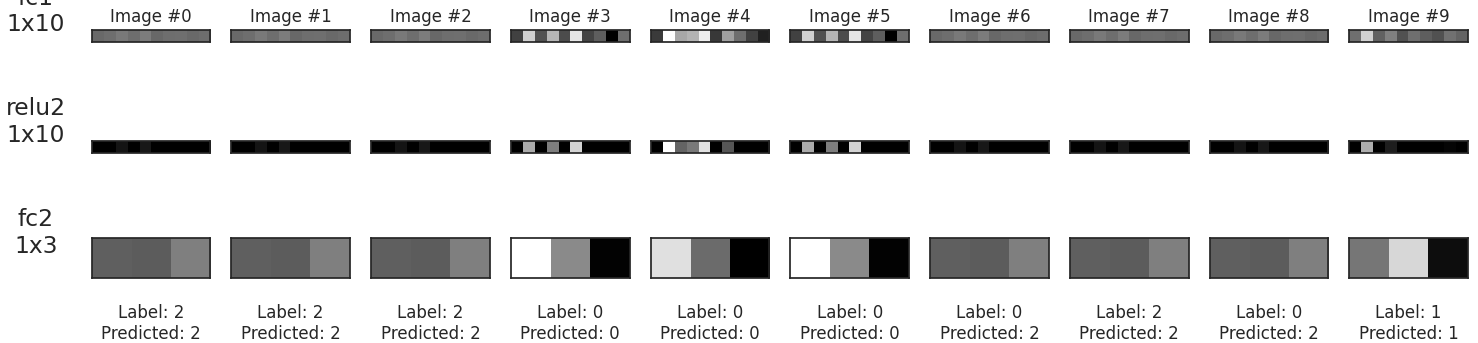

In [83]:
classifier_layers = ['fc1', 'relu2', 'fc2']

with plt.style.context('seaborn-v0_8-white'):
    fig = arch_cnn1.visualize_outputs(classifier_layers, y=labels_batch, yhat=predicted)

### Accucary

So, there are only two wrong predictions, both for class #0 (parallel lines), corresponding to images #6 and #8, as we’ve already seen in the previous section.

In [84]:
arch_cnn1.correct(images_batch,
                  labels_batch)

tensor([[5, 7],
        [3, 3],
        [6, 6]])

In [85]:
## Loader Apply
Architecture.loader_apply(arch_cnn1.val_loader,
                          arch_cnn1.correct)

tensor([[59, 67],
        [55, 62],
        [71, 71]])

# Putting It All Together

## Data Preparation

In [86]:
# Builds tensors from numpy arrays BEFORE split
# Modifies the scale of pixel values from [0, 255] to [0, 1]
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels).long()

# Uses index_splitter to generate indices for training and
# validation sets
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])
# Uses indices to perform the split
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

# We're not doing any data augmentation now
train_composer = Compose([Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])

# Uses custom dataset to apply composed transforms to each set
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# Builds a weighted random sampler to handle imbalanced classes
sampler = make_balanced_sampler(y_train_tensor)

# Uses sampler in the training set to get a balanced data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

## Model Configuration

In [87]:
torch.manual_seed(13)
model_cnn1 = nn.Sequential()

# Featurizer
# Block 1: 1@10x10 -> n_channels@8x8 -> n_channels@4x4
n_channels = 1
model_cnn1.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=n_channels, kernel_size=3))
model_cnn1.add_module('relu1', nn.ReLU())
model_cnn1.add_module('maxp1', nn.MaxPool2d(kernel_size=2))
# Flattening: n_channels * 4 * 4
model_cnn1.add_module('flatten', nn.Flatten())

# Classification
# Hidden Layer
model_cnn1.add_module('fc1', nn.Linear(in_features=n_channels*4*4, out_features=10))
model_cnn1.add_module('relu2', nn.ReLU())
# Output Layer
model_cnn1.add_module('fc2', nn.Linear(in_features=10, out_features=3))

lr = 0.1
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn1 = optim.SGD(model_cnn1.parameters(), lr=lr)

## Model Training

In [88]:
arch_cnn1 = Architecture(model_cnn1, multi_loss_fn, optimizer_cnn1)
arch_cnn1.set_loaders(train_loader, val_loader)
arch_cnn1.train(20)

## Visualizing Filters

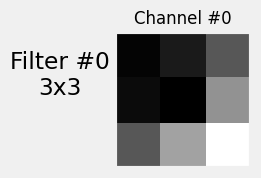

In [89]:
fig_filters = arch_cnn1.visualize_filters('conv1', cmap='gray')

## Capturing Outputs

In [90]:
featurizer_layers = ['conv1', 'relu1', 'maxp1', 'flatten']
classifier_layers = ['fc1', 'relu2', 'fc2']

arch_cnn1.attach_hooks(layers_to_hook=featurizer_layers + classifier_layers)

images_batch, labels_batch = next(iter(val_loader))
logits = arch_cnn1.predict(images_batch)
predicted = np.argmax(logits, 1)

arch_cnn1.remove_hooks()

## Visualizing Feature Maps

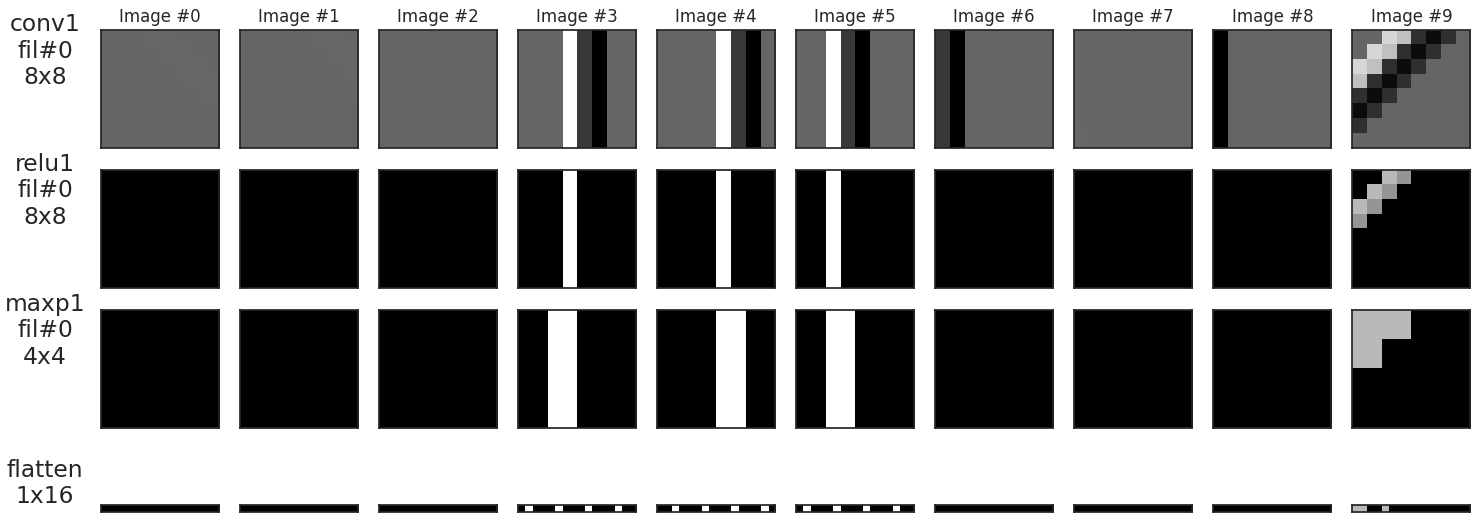

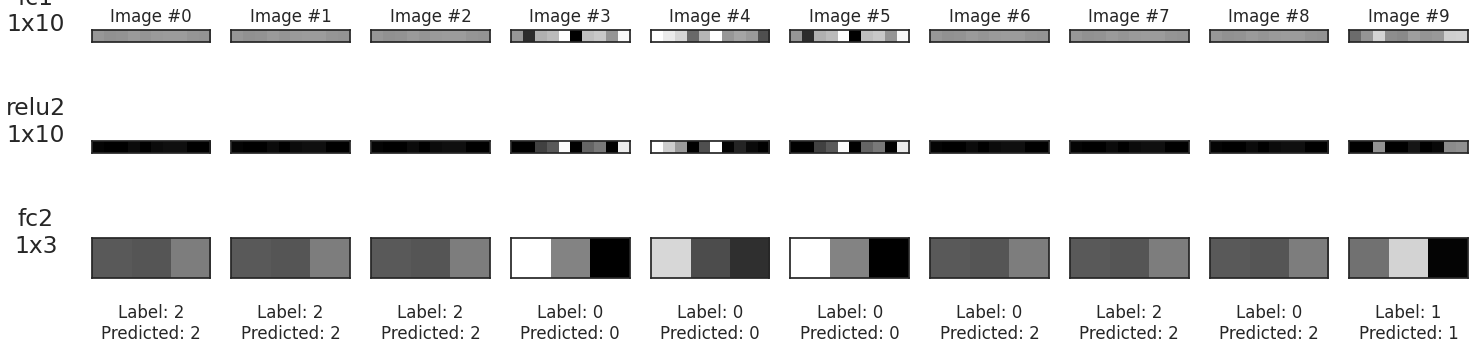

In [92]:
with plt.style.context('seaborn-v0_8-white'):
    fig_maps1 = arch_cnn1.visualize_outputs(featurizer_layers)
    fig_maps2 = arch_cnn1.visualize_outputs(classifier_layers, y=labels_batch, yhat=predicted)

## Accuracy

In [93]:
Architecture.loader_apply(arch_cnn1.val_loader, arch_cnn1.correct)

tensor([[59, 67],
        [55, 62],
        [71, 71]])